# <span style=" display: block; text-align: center; color: #FFFFFF; padding: 0.4em 0.5em;background: #303030;">  Compression with DWT  </span>





You can get the data we will use by the following code. After running this code, you will have a directory, called imagefiltering, on the left side of your screen.

In [ ]:
!git clone https://gitlab-student.centralesupelec.fr/Catherine.Soladie/imagefiltering.git

Cloning into 'imagefiltering'...
remote: Enumerating objects: 14, done.
remote: Total 14 (delta 0), reused 0 (delta 0), pack-reused 14
Unpacking objects: 100% (14/14), 6.86 MiB | 3.79 MiB/s, done.


#0. Previously: DWT on Lena

Below are the functions related to DWT (close to the one you have in the previous notebook). Run the code to get them.

In [ ]:
#@title Usefull functions (decomposition, reconstruction, verify)

import cv2 # install opencv-python
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

#-------------------------------
# FUNCTIONS
#-------------------------------
# Convolution in one direction
def convOneDirection (img, kernel) :
    h = len(kernel)//2
    img_conv = np.zeros(img.shape)
    for i in range (0, len(img)):
        for j in range(h, len(img[0])-h):
            sum=0
            for m in range(len(kernel)):
                sum=sum+kernel[m]*img[i][j-h+m]
            img_conv[i][j] = sum
    return img_conv

# Downsampling in one direction
def downsamplOneDirection(img,firstPoint): 
    img_downsampl = np.zeros((len(img), len(img[0])//2))
    for i in range (0, len(img)):
        for j in range (0, len(img[0])//2):
            img_downsampl[i][j] = img[i][2*j+firstPoint]
    return img_downsampl

# Upsampling in one direction
def upsamplOneDirection(img,firstPoint): 
    img_upsubsampl = np.zeros((len(img), len(img[0])*2))
    for i in range (0, len(img)):
        for j in range (0, len(img[0])):
            img_upsubsampl[i][j*2+firstPoint] = img[i][j]
    return img_upsubsampl

# Mirror the matrix
def mirrorMatrix(img):
    img_miror = np.zeros((len(img[0]), len(img)))
    for i in range (0, len(img[0])):
        for j in range(0, len(img)):
            img_miror[i][j] = img[j][i]
    return img_miror

# Decomposition
def decomposition(img):
    print("")
    print("Image with max amplitude : " + str(np.max(img)))
    print("Starting decomposition...")
    kernelL = [-1, 2, 6, 2, -1] # coefMult*[-1, 2, 6, 2, -1]/8
    kernelH = [-4, 8, -4] # coefMult*[-1, 2, -1]/2
    firstPointL = 0 # first pixel for low pass filters
    firstPointH = 1 # second pixel for high pass filters

    imgL = downsamplOneDirection(convOneDirection(img, kernelL), firstPointL) # LossPass Filter on width + downsample by 2
    imgLcopy = mirrorMatrix(deepcopy(imgL))
    imgLL = mirrorMatrix(downsamplOneDirection(convOneDirection(imgLcopy, kernelL), firstPointL)) # LossPass Filter on height + downsample by 2
    imgLH = mirrorMatrix(downsamplOneDirection(convOneDirection(imgLcopy, kernelH), firstPointH)) # HighPass Filter on height + downsample by 2
    imgH = downsamplOneDirection(convOneDirection(img, kernelH), firstPointH) # LossPass Filter on width + downsample by 2
    imgHcopy = mirrorMatrix(deepcopy(imgH))
    imgHL = mirrorMatrix(downsamplOneDirection(convOneDirection(imgHcopy, kernelL), firstPointL)) # LossPass Filter on height + downsample by 2
    imgHH = mirrorMatrix(downsamplOneDirection(convOneDirection(imgHcopy, kernelH), firstPointH)) # HighPass Filter on height + downsample by 2

    print("Decommposition finished")
    print("Max amplitude of integer images are : " + str(np.max(img)) + " (0 filter), " + str(np.max(imgL))+ " " + str(np.max(imgH))+ " (1 filter, L / H respectively), " + str(np.max(imgLL))+ " " + str(np.max(imgLH))+ " " + str(np.max(imgHL))+ " " + str(np.max(imgHH)) + " (2 filters, LL /  LH / HL / HH respectively)")
    print("Min amplitude of integer images are : " + str(np.min(img)) + " (0 filter), " + str(np.min(imgL))+ " " + str(np.min(imgH))+ " (1 filter, L / H respectively), " + str(np.min(imgLL))+ " " + str(np.min(imgLH))+ " " + str(np.min(imgHL))+ " " + str(np.min(imgHH)) + " (2 filters, LL /  LH / HL / HH respectively)")
    print("The images are " + str(len(imgLL[0])) + " pixels wide and " + str(len(imgLL)) + " pixels high.")
    return [imgLL, imgLH, imgHL, imgHH]

# Reconstruction
def reconstruction(imgLL, imgLH, imgHL, imgHH):
    print("")
    print("Starting recontruction...")
    kernelH = [-1, -2, 6, -2, -1] # coefMult*[-1, -2, 6, -2, -1]/8
    kernelL = [4, 8, 4] # coefMult*[1, 2, 1]/2
    firstPointL = 0 # first pixel for low pass filters
    firstPointH = 1 # second pixel for high pass filters

    imgRL1 = convOneDirection(upsamplOneDirection(mirrorMatrix(imgLL),firstPointL), kernelL)
    imgRL2 = convOneDirection(upsamplOneDirection(mirrorMatrix(imgLH),firstPointH), kernelH)
    imgRL = mirrorMatrix(imgRL1+imgRL2)
    imgRH1 = convOneDirection(upsamplOneDirection(mirrorMatrix(imgHL),firstPointL), kernelL) 
    imgRH2 = convOneDirection(upsamplOneDirection(mirrorMatrix(imgHH),firstPointH), kernelH) 
    imgRH = mirrorMatrix(imgRH1+imgRH2)
    imgR1 = convOneDirection(upsamplOneDirection(imgRL,firstPointL), kernelL)
    imgR2 = convOneDirection(upsamplOneDirection(imgRH,firstPointH), kernelH)
    imgR = imgR1 + imgR2

    print("Reconstruction finished")
    print("Max amplitude of integer images are : " + str(np.max(imgLL))+ " " + str(np.max(imgLH))+ " " + str(np.max(imgHL))+ " " + str(np.max(imgHH)) + " (0 filter), " + str(np.max(imgRL1)) + " " + str(np.max(imgRL2))+ " " + str(np.max(imgRH1))+ " " + str(np.max(imgRH2))+ " " + str(np.max(imgRL))+ " " + str(np.max(imgRH))+ " (1 filter) " + str(np.max(imgR1))+ " " + str(np.max(imgR2))+ " " + str(np.max(imgR)) + " (2 filters)")
    print("Min amplitude of integer images are : " + str(np.min(imgLL))+ " " + str(np.min(imgLH))+ " " + str(np.min(imgHL))+ " " + str(np.min(imgHH)) + " (0 filter), " + str(np.min(imgRL1)) + " " + str(np.min(imgRL2))+ " " + str(np.min(imgRH1))+ " " + str(np.min(imgRH2))+ " " + str(np.min(imgRL))+ " " + str(np.min(imgRH))+ " (1 filter) " + str(np.min(imgR1))+ " " + str(np.min(imgR2))+ " " + str(np.min(imgR)) + " (2 filters)")
    print("The image is " + str(len(imgR[0])) + " pixels wide and " + str(len(imgR)) + " pixels high.")
    return imgR


# Verification
def verification(img, titleimg, imgR, titleimgR, edge):
    print("")
    print("Starting verification...")
    imgCropped = img[edge:len(img)-edge, edge:len(img[0])-edge]
    imgRCropped = imgR[edge:len(img)-edge, edge:len(img[0])-edge]
    plt.subplot(1,3,1),plt.imshow(imgCropped, cmap = 'gray'),plt.title(titleimg), plt.xticks([]), plt.yticks([])
    plt.subplot(1,3,2),plt.imshow(imgRCropped, cmap = 'gray'),plt.title(titleimgR), plt.xticks([]), plt.yticks([])
    maskVerif = np.abs((img-imgR)[edge:len(img)-edge, edge:len(img[0])-edge]) # difference between the 2 images, without the edges 
    deltaValue = np.max(maskVerif)
    print("Mask delta value : " + str(deltaValue) )
    maskVerif[0][0] = 0; maskVerif[0][1] = 255 # to avoid min-max equalization from matplotlib :)
    plt.subplot(1,3,3),plt.imshow(maskVerif, cmap = 'gray'),plt.title('Reconstruction error'), plt.xticks([]), plt.yticks([])
    plt.show()

For this notebook, we will use Lena's image (bmp), instead of imSynth image (bmp), because the synthetic image has lots of values that are the same (white and black), so that compression of such an image can be rather easy. 

Let's start by. applying DWT on Lena.bmp.


The image is 512 pixels wide and 512 pixels high.
The min pixel value of the image is: 28
The max pixel value of the image is: 244

Image with max amplitude : 244
Starting decomposition...
Decommposition finished
Max amplitude of integer images are : 244 (0 filter), 1992.0 608.0 (1 filter, L / H respectively), 16800.0 3200.0 5088.0 2560.0 (2 filters, LL /  LH / HL / HH respectively)
Min amplitude of integer images are : 28 (0 filter), 0.0 -544.0 (1 filter, L / H respectively), 0.0 -3072.0 -4288.0 -3584.0 (2 filters, LL /  LH / HL / HH respectively)
The images are 256 pixels wide and 256 pixels high.


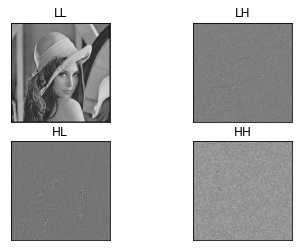

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from copy import deepcopy

img = cv2.imread('/content/imagefiltering/lena.bmp',cv2.IMREAD_GRAYSCALE) # read the image
print("")
print("The image is " + str(len(img[0])) + " pixels wide and " + str(len(img)) + " pixels high.")
print("The min pixel value of the image is: "+ str(np.min(img)))
print("The max pixel value of the image is: "+ str(np.max(img)))

#------------------------------
# MAIN PROCESS SAVING IMAGE WITH DWT
# Save data in a file and rebuild
#------------------------------
coefMult = 8

# encoding 
[imgLL1, imgLH1, imgHL1, imgHH1] = decomposition(img)

# Verify by plotting the different images:
plt.subplot(2,2,1),plt.imshow(imgLL1, cmap = 'gray'), plt.xticks([]), plt.yticks([]), plt.title("LL")
plt.subplot(2,2,2),plt.imshow(imgLH1, cmap = 'gray'), plt.xticks([]), plt.yticks([]), plt.title("LH")
plt.subplot(2,2,3),plt.imshow(imgHL1, cmap = 'gray'), plt.xticks([]), plt.yticks([]), plt.title("HL")
plt.subplot(2,2,4),plt.imshow(imgHH1, cmap = 'gray'), plt.xticks([]), plt.yticks([]), plt.title("HH")
plt.show()

# <span style="padding: 0.4em 0.5em; color: #494949; background: #f4f4f4; border-left: solid 5px #7db4e6; border-bottom: solid 3px #d7d7d7;">1. Compression of an image</span>



The DWT image has a lot of values that are rather identical (in LH, HL and LL).

That is why DTW can be used to compress an image and get a file which is much smaller (in Ko) than the original bmp image. That is what you will verify in this section!



## <span style="border-bottom: double 5px #7db4e6; color: #494949;">1.1. Save a DWT image using quantization</span>

LL, LH, HL and HH are called sub-bands, for they result from different filters.

First of all, we will focus on saving a DTW image. 

The new functions for saving dwt image using quantization (number of bits) are introduced below. 

### <span style="">1.1.1. Understand the values of each sub-band</span>

<b>What are the pixel values of each subband (several possible answers) ?</b>

<div>
  <input type="checkbox">
  <label>Between 0 and 255 for all the subbands</label>
</div>

<div>
  <input type="checkbox">
  <label>Between 100 and 150 for LH and HL</label>
</div>
<div>
  <input type="checkbox">
  <label>Around 90 for HH</label>
</div>


<details>
  <summary> Answer </summary>
None of those answers are true. Test and understand with the code below. 
</details>


 Observe the min and max values of each subband. 

In [ ]:
# encoding 
[imgLL1, imgLH1, imgHL1, imgHH1] = decomposition(img)



Image with max amplitude : 244
Starting decomposition...
Decommposition finished
Max amplitude of integer images are : 244 (0 filter), 1992.0 608.0 (1 filter, L / H respectively), 16800.0 3200.0 5088.0 2560.0 (2 filters, LL /  LH / HL / HH respectively)
Min amplitude of integer images are : 28 (0 filter), 0.0 -544.0 (1 filter, L / H respectively), 0.0 -3072.0 -4288.0 -3584.0 (2 filters, LL /  LH / HL / HH respectively)
The images are 256 pixels wide and 256 pixels high.


Explain those values.
<details>
  <summary> Explanation </summary>
Orignial image has values between 28 and 244. The convolutions change those values and scale them (in negative and/or positive). You should refer to the equation of the convolution, and the values of the kernels.
</details>

### <span style="">1.1.2.  Understand a quantization function</span>

To save the dwt image (LL, HL, LH, and HH) as a bmp with the same size as the original image, we should quantify the signal is 8 bits (values between 0 and 255). 

One solution is proposed in the following code. Read and understand this solution:
  

In [ ]:
# Quantization
def quantizationForSaving(img, sign):
    print("Quantization...")
    if sign: # if we want to keep negative values, we encode the value on 7 bits and save le sign as the 8th bit
        coef=2**(15-7) # we encode the 15 bits on 7 bits
        imgSign = np.sign(img)
        img_comp = np.abs(img)//coef*2 # quantification - we keep the high level information
        img_comp = img_comp + np.where(imgSign==-1, 0, imgSign) # add the sign as the 8th bit
    else:
        coef=2**(15-8) # we encode the 15 bits on 8 bits
        imgSign = np.sign(img)
        img_comp = np.multiply(img,np.where(imgSign==-1, 0, imgSign))//coef # we keep the positive values only for encoding
    print("Max amplitude of image goes from : " +  str(np.max(img)) + " to : " +  str(np.max(img_comp)))
    print("Min amplitude of image goes from : " +  str(np.min(img)) + " to : " +  str(np.min(img_comp)))
    return [img_comp, 0]




### <span style="">1.1.3. Save the dwt image in a bmp file</span>

By using <code> quantizationForSaving </code>, complete the code for saving the dwt image:

In [ ]:
# Save an image from dwt
def saveImageFromSubBands(LL, LH, HL, HH, name):
    img_dwt = np.zeros((2*LL.shape[0], 2*LL.shape[1]))
    listOffsets = [0, 0, 0, 0]
    [img_dwt[0:LL.shape[0], 0:LL.shape[1]], listOffsets[0]] = quantizationForSaving(LL, False) # for LL, we mainly have positive values
    [img_dwt[LL.shape[0]:LL.shape[0]+HL.shape[0], 0:HL.shape[1]], listOffsets[1]] = quantizationForSaving(HL, True)
    [img_dwt[0:LL.shape[0], LL.shape[1]:LL.shape[1]+LH.shape[0]], listOffsets[2]] = quantizationForSaving(LH, True)
    [img_dwt[LL.shape[0]:LL.shape[0]+HH.shape[0], LL.shape[1]:LL.shape[1]+HH.shape[0]], listOffsets[3]] = quantizationForSaving(HH, True)
    cv2.imwrite(name+'.bmp',img_dwt) # write the image
    return [img_dwt, listOffsets]

[Go to one solution](#solution_1_1_3)

<a name="back_1_1_3"></a>
Verify you can save your DTW image with your function via the following code:

In [ ]:
# encoding 
[imgLL1, imgLH1, imgHL1, imgHH1] = decomposition(img)

# Plot and Save image from subbands
[imgdwt, listoffsets] = saveImageFromSubBands(imgLL1, imgLH1, imgHL1, imgHH1, "dwt")


Image with max amplitude : 244
Starting decomposition...
Decommposition finished
Max amplitude of integer images are : 244 (0 filter), 1992.0 608.0 (1 filter, L / H respectively), 16800.0 3200.0 5088.0 2560.0 (2 filters, LL /  LH / HL / HH respectively)
Min amplitude of integer images are : 28 (0 filter), 0.0 -544.0 (1 filter, L / H respectively), 0.0 -3072.0 -4288.0 -3584.0 (2 filters, LL /  LH / HL / HH respectively)
The images are 256 pixels wide and 256 pixels high.
Quantization...
Max amplitude of image goes from : 16800.0 to : 131.0
Min amplitude of image goes from : 0.0 to : 0.0
Quantization...
Max amplitude of image goes from : 5088.0 to : 39.0
Min amplitude of image goes from : -4288.0 to : 0.0
Quantization...
Max amplitude of image goes from : 3200.0 to : 25.0
Min amplitude of image goes from : -3072.0 to : 0.0
Quantization...
Max amplitude of image goes from : 2560.0 to : 28.0
Min amplitude of image goes from : -3584.0 to : 0.0


You should have the dwt bmp file saved on your notebook directory (in the left side of the screen). Open it to verify the DTW image.

<b>What in the size (in Ko) of dtw.bmp compared to the size of lena.bmp ?</b>

<div>
  <input type="checkbox">
  <label>They have the same size in Ko: size in Ko of dtw.bmp = size in Ko of lena.bmp</label>
</div>

<div>
  <input type="checkbox">
  <label>dtw is smaller than lena: size in Ko of dtw.bmp < size in Ko of lena.bmp</label>
</div>

<div>
  <input type="checkbox">
  <label>dtw is bigger tahn lena: size in Ko of dtw.bmp > size in Ko of lena.bmp</label>
</div>


<details>
  <summary> Answer </summary>
Same value ! Both are a bmp file with the same number of pixels :). The value is exactely 263 Ko because we have 512*512 pixels, and grey-level values.
Computation : 512*512*1 = 262 144. 
</details>


<b>What should be the max pixel value of LL ?</b>

<div>
  <input type="checkbox">
  <label>Above 100</label>
</div>

<div>
  <input type="checkbox">
  <label>Between 50 and 100</label>
</div>

<div>
  <input type="checkbox">
  <label>Under 50</label>
</div>


<details>
  <summary> Answer </summary>
Over 100. The original image has a large contrast. After 2 low pass filters, the contrast is still large (low pass filter => blurr).
</details>


<b>What should be the max pixel value of LH ?</b>

<div>
  <input type="checkbox">
  <label>Above 100</label>
</div>

<div>
  <input type="checkbox">
  <label>Between 50 and 100</label>
</div>

<div>
  <input type="checkbox">
  <label>Under 50</label>
</div>


<details>
  <summary> Answer </summary>
Under 50: the contrast of LH is very low.
</details>


We can verify the min and max values of the DWT file for each subband. For that, you are given the reversed function <code>openImageGetSubBands</code.

In [ ]:
# Open an image with dwt
def openImageGetSubBands(name, listoffset):
    # do the opposit treatment as "saveImageFromSubBands"
    img = cv2.imread(name,cv2.IMREAD_GRAYSCALE)
    step = img.shape[0]//2 # we suppose we have a square
    coef=2**(15-8) # for LL, the value is endoded on 8 bits
    tmp = img[0:step, 0:step].astype(float)
    LL = coef*tmp
    coef=2**(15-7) # the value is encoded on 7 bits and the 8th bit is the sign
    tmp = img[step:2*step, 0:step].astype(float)
    HL = coef*((tmp//2)*(tmp%2*2-1))
    tmp = img[0:step, step:2*step].astype(float)
    LH = coef*((tmp//2)*(tmp%2*2-1))
    tmp = img[step:2*step, step:2*step].astype(float)
    HH = coef*((tmp//2)*(tmp%2*2-1))
    return [LL, LH, HL, HH]


Image with max amplitude : 244
Starting decomposition...
Decommposition finished
Max amplitude of integer images are : 244 (0 filter), 1992.0 608.0 (1 filter, L / H respectively), 16800.0 3200.0 5088.0 2560.0 (2 filters, LL /  LH / HL / HH respectively)
Min amplitude of integer images are : 28 (0 filter), 0.0 -544.0 (1 filter, L / H respectively), 0.0 -3072.0 -4288.0 -3584.0 (2 filters, LL /  LH / HL / HH respectively)
The images are 256 pixels wide and 256 pixels high.
Quantization...
Max amplitude of image goes from : 16800.0 to : 131.0
Min amplitude of image goes from : 0.0 to : 0.0
Quantization...
Max amplitude of image goes from : 5088.0 to : 39.0
Min amplitude of image goes from : -4288.0 to : 0.0
Quantization...
Max amplitude of image goes from : 3200.0 to : 25.0
Min amplitude of image goes from : -3072.0 to : 0.0
Quantization...
Max amplitude of image goes from : 2560.0 to : 28.0
Min amplitude of image goes from : -3584.0 to : 0.0


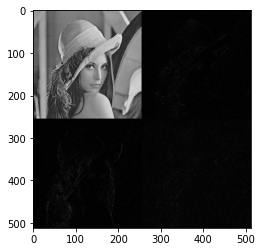

In [ ]:
# encoding 
[imgLL1, imgLH1, imgHL1, imgHH1] = decomposition(img)

# Plot and Save image from subbands
[imgdwt, listoffsets] = saveImageFromSubBands(imgLL1, imgLH1, imgHL1, imgHH1, "dwt")
plt.figure()
plt.imshow(imgdwt, cmap = 'gray')
plt.show()

# Open dwt image
[imgLL1, imgLH1, imgHL1, imgHH1] = openImageGetSubBands("dwt.bmp", listoffsets) # we should save the listoffsets in the header of the image :)



All the pixel values are inbetween 0 and 255. Lots of values are close to 0 !


## <span style="border-bottom: double 5px #7db4e6; color: #494949;">1.2. Verify the DWT image</span>

Verify the reconstruction of the image from the data of the dwt file.



Starting recontruction...
Reconstruction finished
Max amplitude of integer images are : 16768.0 3072.0 4864.0 2560.0 (0 filter), 134144.0 20992.0 38912.0 17408.0 126976.0 37888.0 (1 filter) 1015808.0 259328.0 1001472.0 (2 filters)
Min amplitude of integer images are : 0.0 -3072.0 -4096.0 -3584.0 (0 filter), 0.0 -22016.0 -32768.0 -23296.0 0.0 -33792.0 (1 filter) 0.0 -218624.0 0.0 (2 filters)
The image is 512 pixels wide and 512 pixels high.

Starting verification...
Mask delta value : 8.0


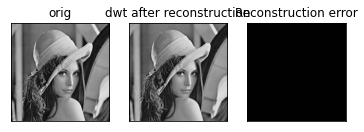

In [ ]:
# reconstruction
imgR1 = reconstruction(imgLL1, imgLH1, imgHL1, imgHH1)
verification(img, 'orig', imgR1//coefMult**4, 'dwt after reconstruction', 6)

What do you notice? How can you explain it? 

##1.3 Reduce the size of the data

We still have the same size of the data, but we do have lots of values that are close to 0. How can we compress the data ?

<b>What would be the value in Ko if we keep 8 bits for LL and take 7 bits for LH, HL and HH ?</b>

<details>
  <summary> Answer </summary>
Computation: 1/4*512² * 8 + 3/4*512² * 7 = 1900544 bits = 237 568 octets = 238 Ko
</details>

<b>On Lena's image, how many bits do we need to save LH ?</b>

<details>
  <summary> Answer </summary>
6 bits for 2^5 = 32 < 39 < 2^6=64
</details>

<b>On Lena's image, how many bits do we need to save HL ?</b>

<details>
  <summary> Answer </summary>
5 bits for 2^4 = 16 < 25 < 2^5 = 32
</details>

<b>On Lena's image, how many bits do we need to save HH ?</b>

<details>
  <summary> Answer </summary>
5 bits for 2^4 = 16 < 28 < 2^5 = 32
</details>

<b>Imagine we know those previous values (number of bits for LL, LH, HL and HH), what is the size of the compressed data ? </b>

<details>
  <summary> Answer </summary>
1/4*512² * 8 + 1/4*512² * 6 + 2/4*512² * 5 = 1572864 bits = 196 608 octets = 197Ko
</details>

<b>How much information did we loose ? </b>

<details>
  <summary> Answer </summary>
We get the exact same image as in 1.2.
</details>


# <span style="padding: 0.4em 0.5em; color: #494949; background: #f4f4f4; border-left: solid 5px #7db4e6; border-bottom: solid 3px #d7d7d7;">2. Towards JPEG200</span>

Dwt is used in JPEG2000. One of the main difference with JPEG is the use of wavelets. Let's look at some more ways to use wavelets to save the image.

Note that many other solutions can be imagine to reduce the number of information (compression). 

## <span style="border-bottom: double 5px #7db4e6; color: #494949;">2.1. Quantization of sub-bands</span>

In 1.1.2, we propose a quantization for saving DWT image, and in 1.3, we propose a quantization of sub-bands specific for HL, LH and HH sub-bands.

Having a 1-level decomposition on a 40\*40 file with: 8 bits for LL, 7 bits for HL and LH and 5 bits for HH will reduce the size of the bmp image from 12 800 (40\*40\*8) to 10 080 (20\*20\*8+2\*20\*20\*7+20\*20\*5), with few/no loss. If we couple that with multi-resolution (see next paragraph), we can gain even more.
<p>
   You can also test 8 bits for LL, 0 bits for HL, LH and HH (replace by black). Size is now 3 200 for a 40*40 file (exactly 1/4*12 800)! But loss is more important. More specifically, the image is blurred, for we deleted the edges information.
   
   You can easily test it on Lena's image :).

[Go to one solution](#solution_2_1)

<a name="back_2_1"></a>
## <span style="border-bottom: double 5px #7db4e6; color: #494949;">2.2. Multi-resolution encoding</span>

Using dwt, most of the information is encoded in LL sub-band. Multi-resolution encoding consist at performing iteratively dwt on the LL sub-bands.

The resulting image for a 3 level decomposition is:
![lena3decomp.png](https://drive.google.com/uc?id=10HpCTkdJkfZE9Uweqax4To-SyoGMqGJ3
)


Propose a quantization for the different parts and compute the size of the final file.

Compare the size of a bmp file, a JPEG file and a JPEG2000 file.

<a name="back_2_2"></a>
[Go to one solution](#solution_2_2)

# <span style=" display: block; text-align: center; color: #FFFFFF; padding: 0.4em 0.5em;background: #303030;">  Solutions </span>

<div id="sol_1"/>


<a name="solution_1_1_3"></a>
# 1.1.3. Save the dwt image in a bmp file

In [ ]:
# Save an image from dwt
def saveImageFromSubBands(LL, LH, HL, HH, name):
    img_dwt = np.zeros((2*LL.shape[0], 2*LL.shape[1]))
    listOffsets = [0, 0, 0, 0]
    [img_dwt[0:LL.shape[0], 0:LL.shape[1]], listOffsets[0]] = quantizationForSaving(LL, False) # for LL, we mainly have positive values
    [img_dwt[LL.shape[0]:LL.shape[0]+HL.shape[0], 0:HL.shape[1]], listOffsets[1]] = quantizationForSaving(HL, True)
    [img_dwt[0:LL.shape[0], LL.shape[1]:LL.shape[1]+LH.shape[0]], listOffsets[2]] = quantizationForSaving(LH, True)
    [img_dwt[LL.shape[0]:LL.shape[0]+HH.shape[0], LL.shape[1]:LL.shape[1]+HH.shape[0]], listOffsets[3]] = quantizationForSaving(HH, True)
    cv2.imwrite(name+'.bmp',img_dwt) # write the image
    return [img_dwt, listOffsets]

[Back.](#back_1_1_3)

<a name="solution_2_1"></a>
# 2.1. Quantization of sub-bands


Starting recontruction...
Reconstruction finished
Max amplitude of integer images are : 16768.0 0.0 0.0 0.0 (0 filter), 134144.0 0.0 0.0 0.0 134144.0 0.0 (1 filter) 1073152.0 0.0 1073152.0 (2 filters)
Min amplitude of integer images are : 0.0 0.0 0.0 0.0 (0 filter), 0.0 0.0 0.0 0.0 0.0 0.0 (1 filter) 0.0 0.0 0.0 (2 filters)
The image is 512 pixels wide and 512 pixels high.

Starting verification...
Mask delta value : 70.0


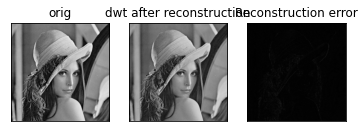

In [ ]:
imgBlack = np.zeros((256,256))
imgR1 = reconstruction(imgLL1, imgBlack, imgBlack, imgBlack)
verification(img, 'orig', imgR1//coefMult**4, 'dwt after reconstruction', 6)

[Back.](#back_2_1)

<a name="solution_2_2"></a>
# 2.2. Multi-resolution encoding

With Lena file: <p>
    <it><ul>BMP file is 263 Ko </ul>
<ul>JPEG file is 91 Ko </ul>
   <ul> JPEG2000 depends on the compression rate. Example: the file lena.jp2 in the imagefiltering directory (on the left side of your scrren) is only 10Ko. </ul></it></p>







[Back.](#back_2_2)